In [31]:
# BAZA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from argparse import Namespace
from collections import Counter
import string
import os
# OSNOVA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

# Used Classes

In [2]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        self._token_to_idx = dict()
        if token_to_idx is not None:
            self._token_to_idx = token_to_idx
        self._idx_to_token = {
            index: token
            for token, index in self._token_to_idx
        }
    
    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        if token in self._token_to_idx:
            return self._token_to_idx[token]
        raise KeyError(f"Token {token} is not in Vocabulary")
   
    def lookup_index(self, index):
        if index in self._idx_to_token:
            return self._idx_to_token[index]
        raise KeyError(f"No token with index {index} in Vocabulary")        
        
    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, 
                 mask_token="<MSK>", unk_token="<UNK>",
                 begin_token="<BGN>", end_token="<END>"
                ):
        super(SequenceVocabulary, self).__init__(token_to_idx)
        
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_token = begin_token
        self._end_token = end_token
        
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_index = self.add_token(self._begin_token)
        self.end_index = self.add_token(self._end_token)

In [4]:
class Vectorizer(object):
    def __init__(self, vocab=None):
        self.vocab = vocab
        
    @classmethod
    def from_dataframe(cls, df, cutoff=10):
        vocab = SequenceVocabulary()
        
        tokens_counter = Counter()
        for text in df.text:
            for token in text.split(" "):
                tokens_counter[token] += 1
                
        for token, count in tokens_counter.items():
            if count >= cutoff:
                vocab.add_token(token)
        
        return cls(vocab)
    
    def vectorize(self, description, vector_length=-1):
        # tokens
        indices = [self.vocab.begin_index]
        for token in description.split(" "):
            indices.append(self.vocab.lookup_token(token))
        indices.append(self.vocab.end_index)
        # filling
        if vector_length < 0:
            vector_length = len(indices)
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.vocab.mask_index
        return out_vector

In [13]:
class JobsDataset(Dataset):
    def __init__(self, data, vectorizer):
        self.data = data
        self._vectorizer = vectorizer
        
        get_length = lambda text: len(text.split(" "))
        
        self._max_length = max(self.data.text.apply(get_length)) + 2 
    
    def __getitem__(self, index):
        x_data = self.vectorizer.vectorize(self.data.text.iloc[index], self._max_length)
        y_target = self.data.target.iloc[index]
        return {
            'x_data': x_data,
            'y_target': y_target
        }
    
    def __len__(self):
        return len(self.data)
    
    def get_num_batches(self, batch_size):
        return len(self) // batch_size
    
    @classmethod
    def load_dataset_and_make_vectorizer(cls, df_path):
        df = pd.read_csv(df_path)
        vectorizer = Vectorizer.from_dataframe(df)
        return cls(df, vectorizer)

In [6]:
def seed_everywhere(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
def generate_batches(dataset, batch_size, shuffle=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    for data_dict in dataloader:
        out_dict = dict()
        for name, data in data_dict.items():
            out_dict[name] = data_dict[name].to(device)
        yield out_dict

In [33]:
args = Namespace(
    #dirs
    train_data_path = 'data/preprocessed_data_train.csv',
    val_data_path = 'data/preprocessed_data_val.csv',
    model_filepath='data/model_storage/model.pth',
    #model hyper params
    seed = 1,
    dropout_p = 0.2,
    embedding_size = 100,
    hidden_size = 200,
    batch_size = 128,
    num_epochs = 100,
    learning_rate=0.001,
    early_stopping_criteria=5,
    #utils
    use_cuda = True,
)

train_state = {
    'stop_early': False,
    'early_stopping_step': 0,
    'early_stopping_best_val': 1e8,
    'learning_rate': args.learning_rate,
    'epoch_index': 0,
    'train_loss': [],
    'val_loss': [],
    'test_loss': -1,
    'model_filename': args.model_filepath,
}

def update_train_state(args, model, train_state):
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        print(f"Saving model on {train_state['epoch_index']} epoch")
        train_state['stop_early'] = False
    elif train_state['epoch_index'] >= 1:
        loss_t = train_state['val_loss'][-1]
        
        if loss_t >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1
        else:
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                print(f"Saving model on {train_state['epoch_index']} epoch")
            train_state['early_stopping_step'] = 0
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

In [34]:
class SalaryPredictor(nn.Module):
    def __init__(self, embedding_size, num_embeddings, hidden_size, dropout_p, padding_idx):
        super(SalaryPredictor, self).__init__()
        
        self.emb = nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_size,
            padding_idx=padding_idx,
        )
        self.convert = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=hidden_size),
            nn.ELU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ELU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ELU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ELU(),
        )
        self._dropout_p = dropout_p
        self.lin1 = nn.Linear(in_features=hidden_size, out_features=int(hidden_size / 2))
        self.lin2 = nn.Linear(in_features=int(hidden_size / 2), out_features=1)
    
    def forward(self, x_in):
        x_embedded = self.emb(x_in)
        x_out = self.convert(x_embedded)
        x_out = F.dropout(features, p=self._dropout_p)
        x_out = F.relu(F.dropout(self.lin1(x_out), p=self._dropout_p))
        x_out = self.lin2(x_out)
        
        return x_out

In [35]:
# cuda setting
if not torch.cuda.is_available():
    args.use_cuda = False
    
args.device = torch.device("cuda" if args.use_cuda else "cpu")
print(f"USE CUDA -> {args.use_cuda}")

USE CUDA -> False


In [36]:
# dataset and classifier preparing

train_dataset = JobsDataset.load_dataset_and_make_vectorizer(args.train_data_path)
vectorizer = train_dataset._vectorizer
val_dataset = JobsDataset(pd.read_csv(args.val_data_path), vectorizer)

model = SalaryPredictor(
    embedding_size=args.embedding_size, 
    num_embeddings=len(vectorizer.vocab),
    hidden_size=args.hidden_size,
    dropout_p=args.dropout_p,
    padding_idx=0
)

In [37]:
max_length = max(train_dataset._max_length, val_dataset._max_length)
train_dataset._max_length = max_length
val_dataset._max_length = max_length

In [38]:
print(model)

SalaryPredictor(
  (emb): Embedding(6915, 100, padding_idx=0)
  (convert): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): ELU(alpha=1.0)
  )
  (lin1): Linear(in_features=200, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=1, bias=True)
)


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/152 [00:00<?, ?it/s]

val:   0%|          | 0/38 [00:00<?, ?it/s]

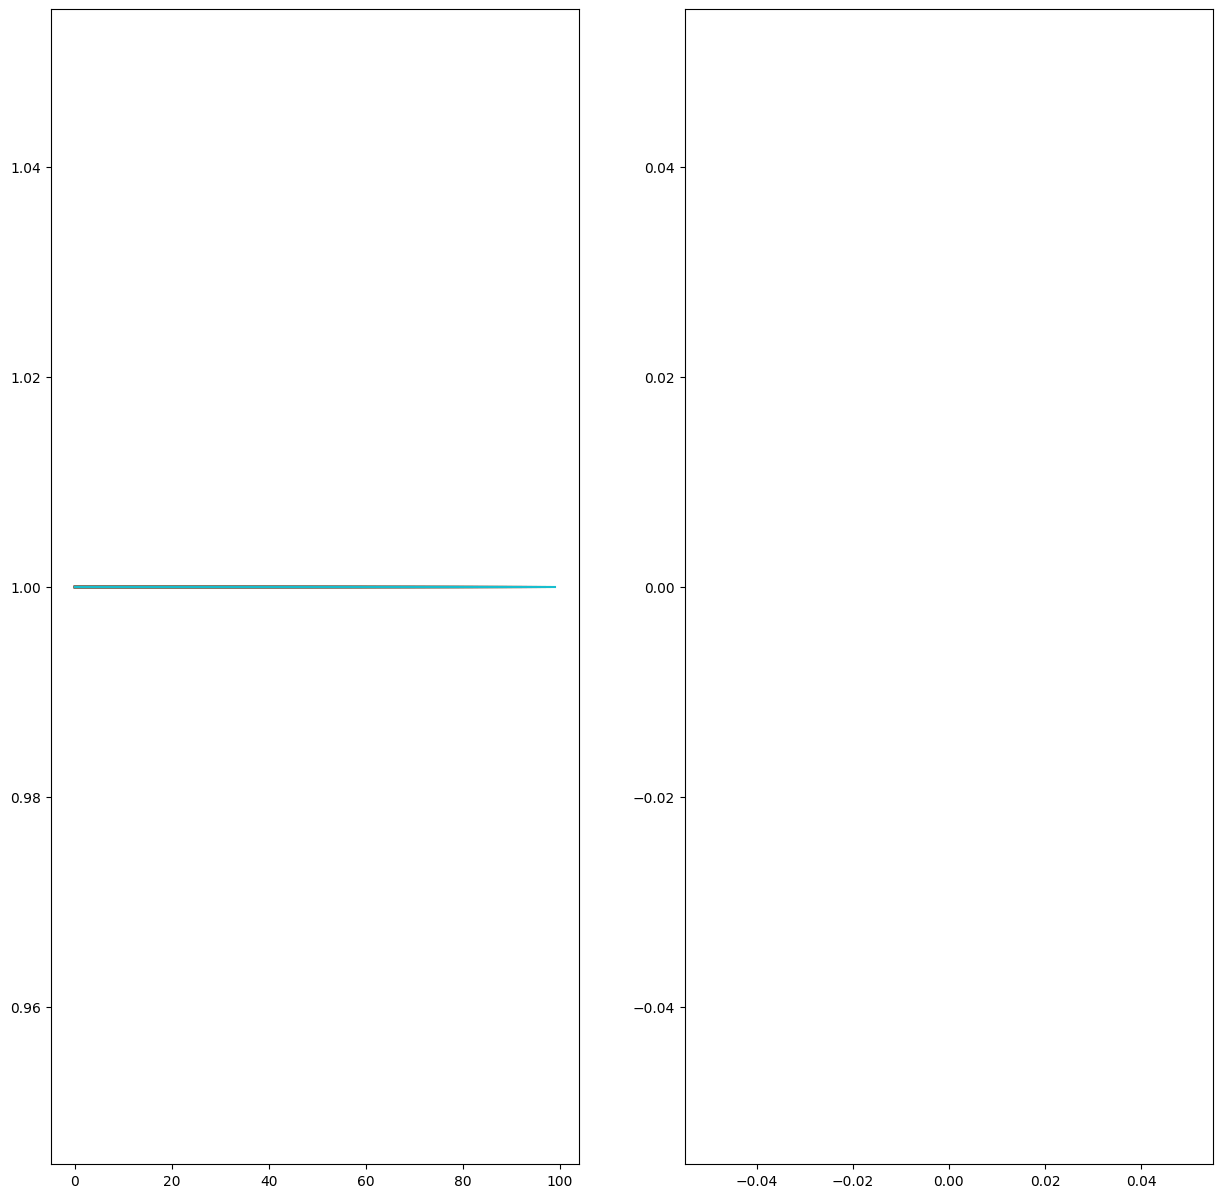

In [32]:
model = model.to(args.device)
loss = nn.MSELoss()
optimizer = opt.Adam(params=model.parameters(), lr=args.learning_rate)
scheduler = opt.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

epoch_bar = tqdm(desc="epoch", total=args.num_epochs, position=0)
train_bar = tqdm(desc="train", total=train_dataset.get_num_batches(args.batch_size), position=1, leave=True)
val_bar = tqdm(desc="val", total=val_dataset.get_num_batches(args.batch_size), position=1, leave=True)

fig, ax = plt.subplots(1, 2, figsize=(15,15))

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index
        # train
        batch_generator = generate_batches(dataset, args.batch_size device=args.device)
        
        
        
except KeyboardInterrupt:
    print("KeyboardInterrupt")